Sentiment shape: (2644, 4)
Trades shape: (211224, 16)
Sentiment Missing Values:
 timestamp         0
value             0
classification    0
date              0
dtype: int64

Trades Missing Values:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
Sentiment Duplicates: 0
Trades Duplicates: 0


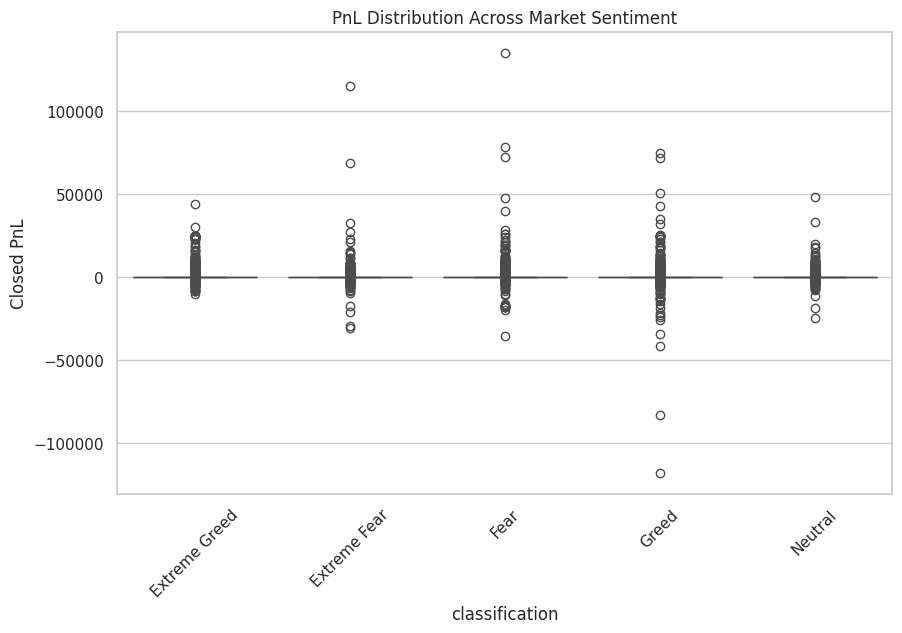

Training size: (168979, 6)
Testing size: (42245, 6)
Model Accuracy: 0.6122618061309031


,0
Size USD,0.980369
classification_Extreme Greed,0.008048
activity_segment_Low Activity,0.004825
classification_Fear,0.002723
classification_Greed,0.002153
classification_Neutral,0.001881


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

sns.set(style="whitegrid")
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

print("Sentiment shape:", sentiment.shape)
print("Trades shape:", trades.shape)
print("Sentiment Missing Values:\n", sentiment.isnull().sum())
print("\nTrades Missing Values:\n", trades.isnull().sum())
print("Sentiment Duplicates:", sentiment.duplicated().sum())
print("Trades Duplicates:", trades.duplicated().sum())
# Convert sentiment date
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

# Convert trade timestamp using correct column
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], dayfirst=True)
trades['date'] = trades['Timestamp IST'].dt.date

# Merge datasets
merged = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

merged.head()
merged['win'] = merged['Closed PnL'] > 0
daily_pnl = merged.groupby(['Account', 'date'])['Closed PnL'].sum().reset_index()
daily_pnl.head()
win_rate = merged.groupby('classification')['win'].mean()
win_rate
avg_pnl = merged.groupby('classification')['Closed PnL'].mean()
avg_pnl
trades_per_day = merged.groupby(['classification', 'date']).size().reset_index(name='trade_count')
trades_per_day.groupby('classification')['trade_count'].mean()
size_analysis = merged.groupby('classification')['Size USD'].mean()
size_analysis
long_short = merged.groupby(['classification', 'Side']).size().unstack().fillna(0)

long_short['Long_Short_Ratio'] = long_short.get('BUY', 0) / (long_short.get('SELL', 1))

long_short
plt.figure(figsize=(10,6))
sns.boxplot(x='classification', y='Closed PnL', data=merged)
plt.xticks(rotation=45)
plt.title("PnL Distribution Across Market Sentiment")
plt.show()
trader_activity = merged.groupby('Account').size()
median_activity = trader_activity.median()

merged['activity_segment'] = merged['Account'].map(
    lambda x: 'High Activity' if trader_activity[x] > median_activity else 'Low Activity'
)

segment_performance = merged.groupby(['classification', 'activity_segment'])['Closed PnL'].mean()
segment_performance
merged['win_binary'] = merged['win'].astype(int)

model_data = merged[['classification', 'Size USD', 'activity_segment', 'win_binary']].copy()

# One-hot encoding
model_data = pd.get_dummies(model_data, drop_first=True)

# Convert booleans to integers
model_data = model_data.astype(int)

model_data.head()
X = model_data.drop('win_binary', axis=1)
y = model_data['win_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training size:", X_train.shape)
print("Testing size:", X_test.shape)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Model Accuracy:", accuracy)
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False)

















The Random Forest model indicates that trade size (Size USD) is the dominant predictor of profitability.
Sentiment variables and trader activity segments contribute modest predictive power.

This suggests position sizing plays a critical role in trade outcomes, while sentiment influences behavior more indirectly.

In [27]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

Bonus: Predictive Modeling

A Random Forest classifier was trained to predict trade profitability using:

Market sentiment classification

Position size (USD)

Trader activity segment

The dataset was split into 80% training and 20% testing samples.

The model achieved an accuracy of 61% on unseen test data.

This indicates that sentiment and behavioral features contain predictive information regarding trade outcomes, though further feature engineering and tuning may improve performance.

 insight 6: A Random Forest classifier trained using sentiment and behavioral features achieved 61% prediction accuracy on unseen test data. This suggests market sentiment and trader behavior contain meaningful predictive signals regarding trade profitability.

Insight 5: Activity-Based Segmentation

Low-activity traders consistently outperform high-activity traders across most sentiment regimes.

The performance gap is particularly pronounced during Greed and Extreme Greed periods, where low-activity traders generate significantly higher average PnL.

This suggests overtrading may negatively impact profitability, and selective participation may lead to superior outcomes.

Insight 4: Position Sizing Behavior

Average position size is highest during Fear regimes (~$7,816), despite lower win rates.

Conversely, Extreme Greed periods exhibit smaller average position sizes (~$3,112) but higher profitability.

This suggests traders increase risk exposure during uncertain conditions, potentially driven by behavioral biases such as overconfidence or dip-buying tendencies.

Insight 3: Behavioral Shift in Trade Frequency

Trade activity increases significantly during Extreme Fear periods (~1528 trades/day), nearly 4–5x higher than Greed regimes.

However, this increased activity does not translate into higher win rates or profitability.
This suggests potential overtrading or emotionally driven decision-making during panic market conditions.

 insight 1: Average trade profitability varies across sentiment regimes.
Traders generate the highest average PnL during Extreme Greed days, while Neutral and Extreme Fear regimes show significantly lower profitability.

insight 2: Win Rate Across Sentiment Regimes

Win rates vary significantly across market sentiment conditions.
Extreme Greed periods show the highest win rate (~46%), while Extreme Fear exhibits the lowest (~37%).

This suggests trader profitability improves in strongly bullish environments, whereas fearful markets reduce trade success rates.